In [81]:
import os
import matplotlib.pyplot as plt
import numpy as np
import shapefile
import flopy
from gsflow.builder import GenerateFishnet
import os
import utm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import flopy
import gsflow
from gsflow.builder import PrmsBuilder
from gsflow.builder import GenerateFishnet
from gsflow.builder import FlowAccumulation
from gsflow.builder import ModflowBuilder
from gsflow.builder import ControlFileBuilder
# check if numba is installed
try:
    from numba import jit
    multithread = False
except ImportError:
    multithread = True
    
import pandas as pd
# silence pandas setting with copy warning
pd.options.mode.chained_assignment = None
from gsflow.builder import builder_utils as bu

In [2]:
raster = os.path.join('..', 'geodata', 'DEMutm.tif')

# set our cell size in meters.
dx = 200
dy = 200
modelgrid = GenerateFishnet(raster, xcellsize=dx, ycellsize=dy)
print(type(modelgrid))
print(modelgrid.__class__.__bases__)
print(modelgrid.extent)

<class 'gsflow.builder.fishnet.GenerateFishnet'>
(<class 'flopy.discretization.structuredgrid.StructuredGrid'>,)
(263833.9619, 281433.9619, 5944310.2557, 5963310.2557)


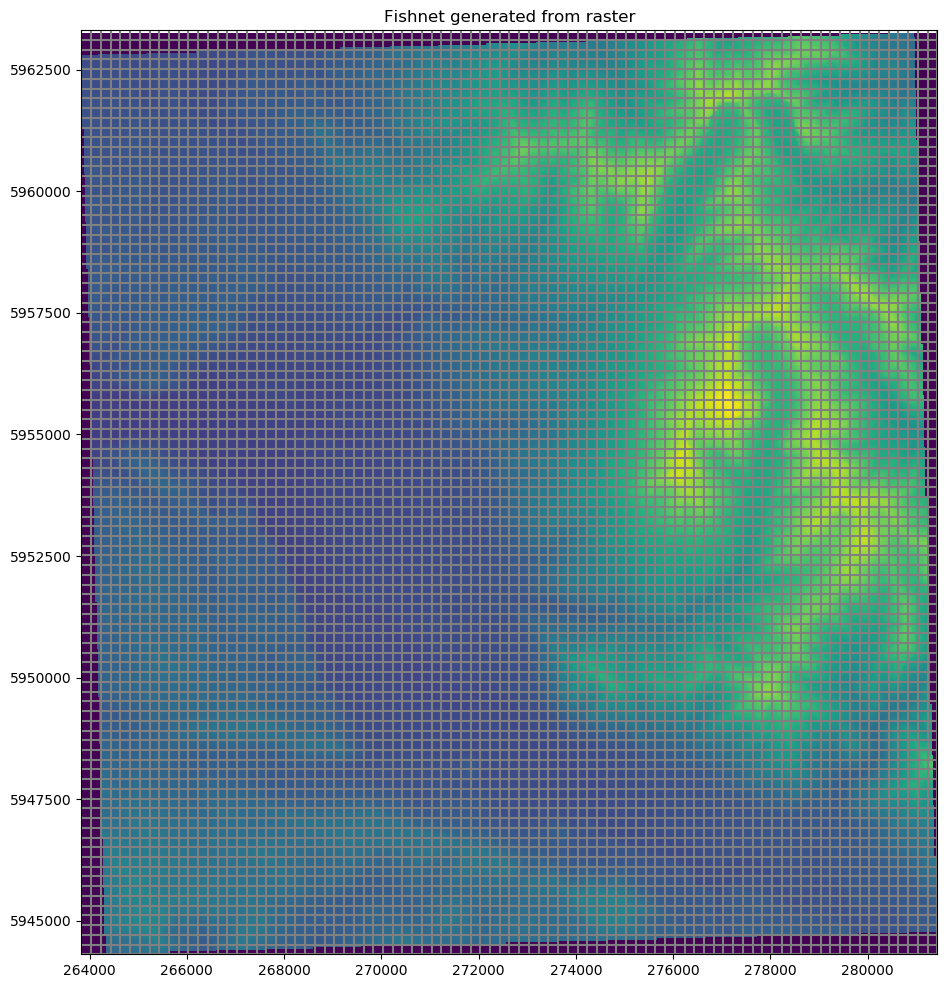

In [3]:
# let's load the raster for plotting
robj = flopy.utils.Raster.load(raster)

# plot the fishnet on top of the raster imagery
fig, ax = plt.subplots(figsize=(12, 12))

robj.plot(ax=ax)
modelgrid.plot(ax=ax)
ax.set_title("Fishnet generated from raster")
plt.show();

In [4]:
cellsize = dx

bbox = [266000,281000,5947500, 5960000]

modelgrid = GenerateFishnet(bbox, xcellsize=dx, ycellsize=dy)
extent = modelgrid.extent
print(modelgrid)
print(extent)

print(modelgrid.extent)

xll:266000; yll:5947500; rotation:0.0; units:undefined; lenuni:0
(266000.0, 281000.0, 5947500.0, 5960100.0)
(266000.0, 281000.0, 5947500.0, 5960100.0)


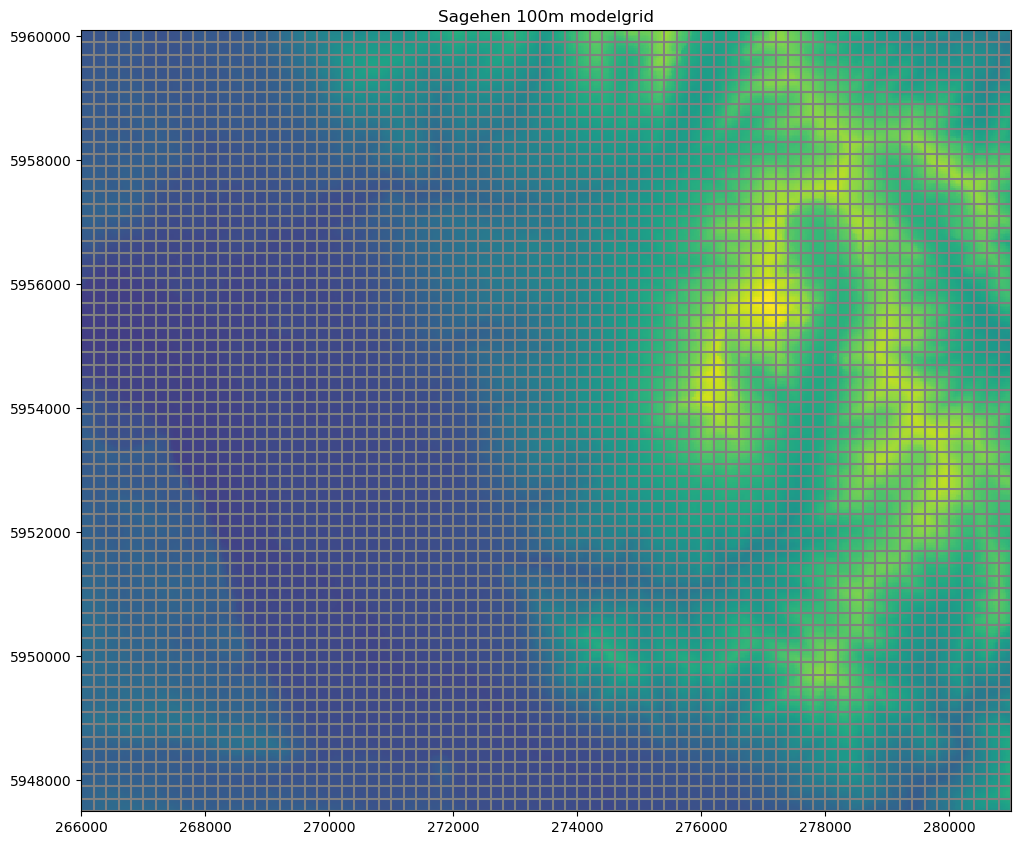

In [5]:
# plot the fishnet on top of the raster imagery
fig, ax = plt.subplots(figsize=(12, 12))

robj.plot(ax=ax)
modelgrid.plot(ax=ax)
ax.set_title("Sagehen 100m modelgrid")
plt.show();

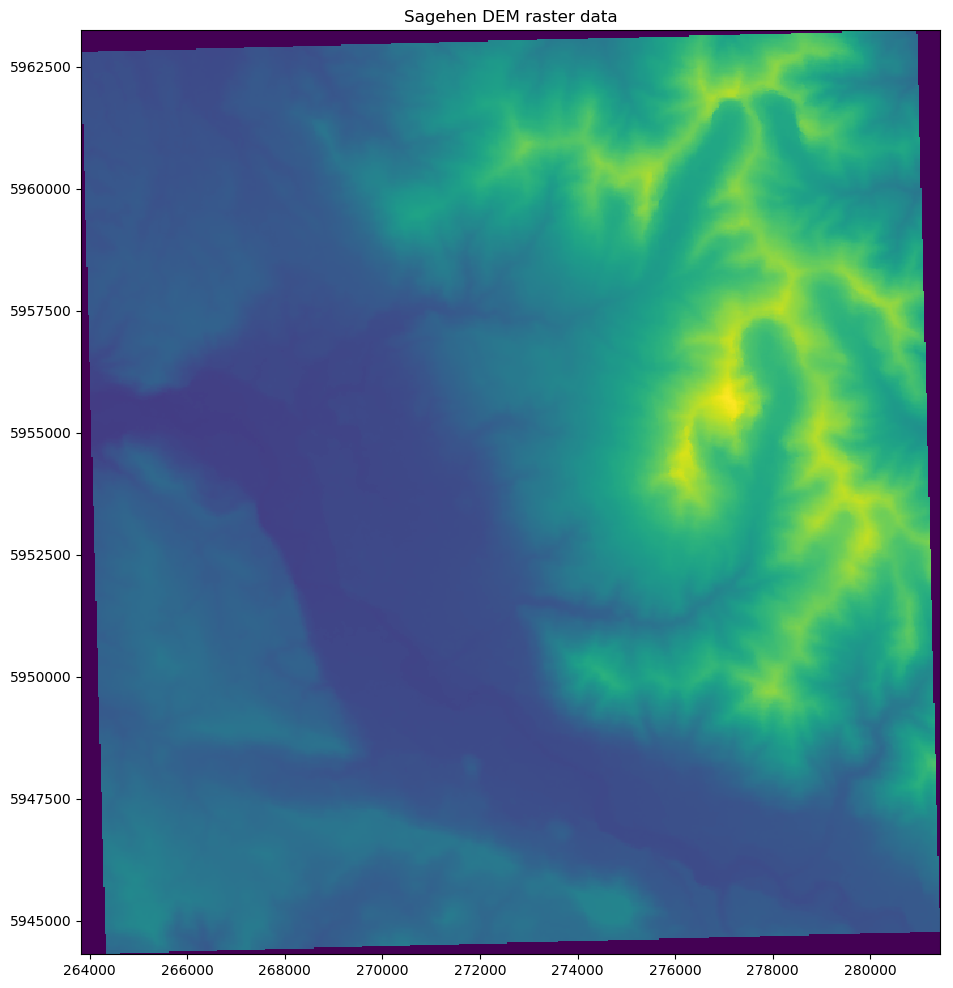

In [6]:
grid_file = os.path.join("..","geodata", "esteros_100m_grid.bin")

modelgrid.write(grid_file)

raster = os.path.join('..','geodata', 'DEMutm.tif')

robj = gsflow.utils.Raster.load(raster)

# plot the raster
fig, ax = plt.subplots(figsize=(12, 12))

robj.plot(ax=ax)
ax.set_title("Sagehen DEM raster data")
plt.show();

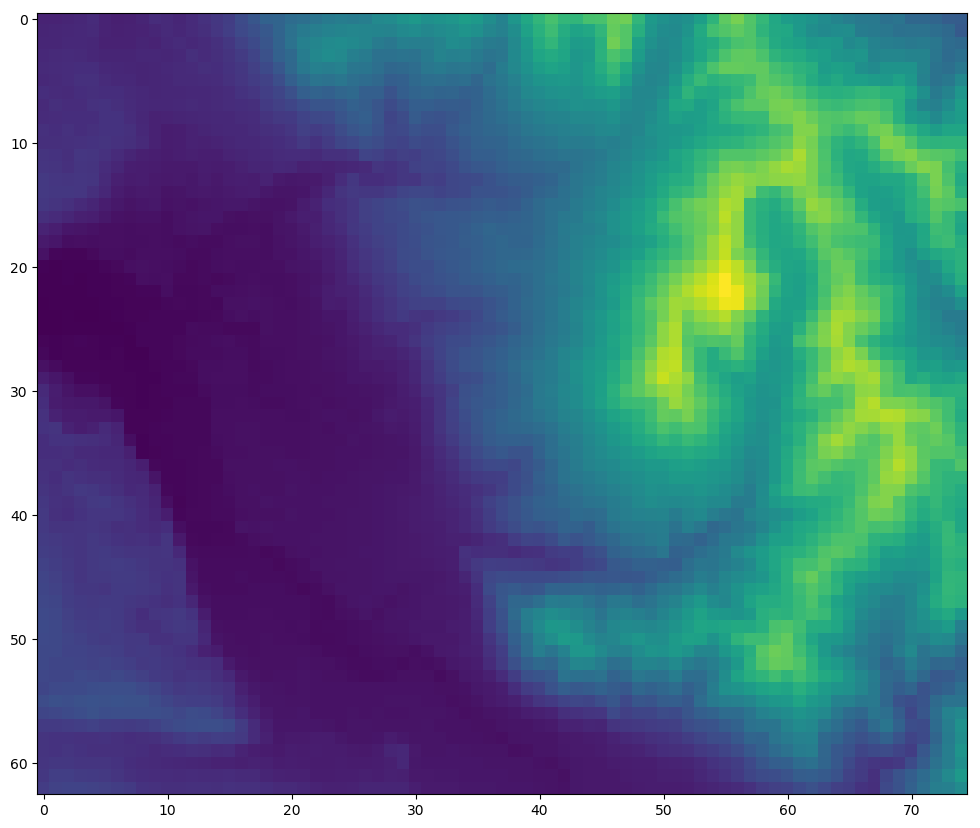

In [7]:
# generate a dummy modelgrid
# modelgrid = GenerateFishnet(raster, xcellsize=50, ycellsize=50)

# now resample the loaded raster to an array of dimension nrow, ncol
array = robj.resample_to_grid(modelgrid, robj.bands[0], method="nearest")
# now to visualize using flopy and matplotlib
# now to visualize using flopy and matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

plt.imshow(array)

# Load the binary modelgrid file
mg_file = os.path.join("..", "geodata", "esteros_100m_grid.bin")

modelgrid = GenerateFishnet.load_from_file(mg_file)

robj = gsflow.utils.Raster.load(raster)

# use multithreading with "median" method if Numba is not installed to improve speed. 
# This however still takes time and is the bottleneck in the model building process
dem_data = robj.resample_to_grid(
    modelgrid, 
    robj.bands[0], 
    multithread=multithread, 
    thread_pool=12
)

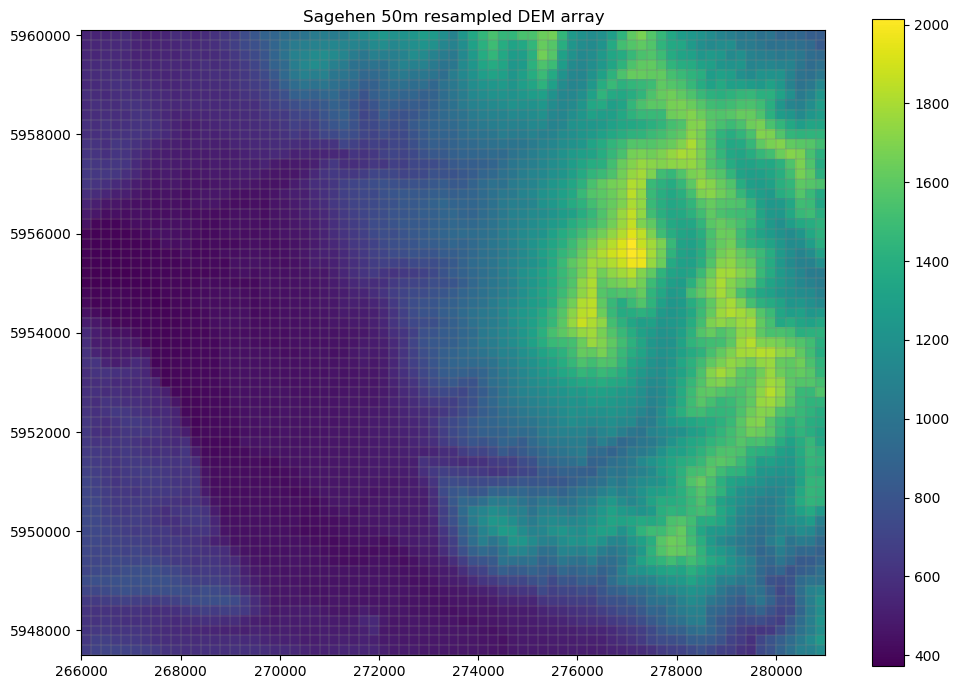

In [8]:
# plot the resampled DEM with the modelgrid overlain
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
ax = pmv.plot_array(
    dem_data
)
lc = pmv.plot_grid(color="grey", lw=0.3)
plt.title("Sagehen 50m resampled DEM array")
plt.colorbar(ax, shrink=0.7)
plt.show();

In [9]:
dem_file = os.path.join('..',"geodata", "esteros_100m_dem_median.txt")

np.savetxt(dem_file, dem_data, delimiter="  ")

In [10]:
# define the input and output data paths
input_ws = os.path.join('..',"geodata")
output_ws = os.path.join("..", "temp")

# define the modelgrid and resampled DEM data paths
mg_file = os.path.join(input_ws, "esteros_100m_grid.bin")
dem_data = os.path.join(input_ws, "esteros_100m_dem_median.txt")

# load modelgrid
modelgrid = GenerateFishnet.load_from_file(mg_file)
dem_data = np.genfromtxt(dem_data)

# instatiate the FlowAccumulation object
fa = FlowAccumulation(
    dem_data,
    modelgrid.xcellcenters,
    modelgrid.ycellcenters,
    verbose=True
)
# use a small breaching tolerance and dijkstra's algorithm in this example
flow_directions = fa.flow_directions(dijkstra=True, breach=0.001)

Applying Dijkstra solution to resolve flat area:
pass # 0
Applying Dijkstra solution to resolve flat area:
pass # 0
pass # 20
Applying Dijkstra solution to resolve flat area:
pass # 0
pass # 20
pass # 40
Applying Dijkstra solution to resolve flat area:
pass # 0
Applying Dijkstra solution to resolve flat area:
pass # 0
Applying Dijkstra solution to resolve flat area:
pass # 0
Applying Dijkstra solution to resolve flat area:
pass # 0
Applying Dijkstra solution to resolve flat area:
pass # 0
pass # 20
Applying Dijkstra solution to resolve flat area:
pass # 0
Applying Dijkstra solution to resolve flat area:
pass # 0
pass # 20
Applying Dijkstra solution to resolve flat area:
pass # 0
pass # 20
pass # 40
Applying Dijkstra solution to resolve flat area:
pass # 0
Applying Dijkstra solution to resolve flat area:
pass # 0
pass # 20
Applying Dijkstra solution to resolve flat area:
pass # 0
Applying Dijkstra solution to resolve flat area:
pass # 0
pass # 20
Applying Dijkstra solution to resolve fl

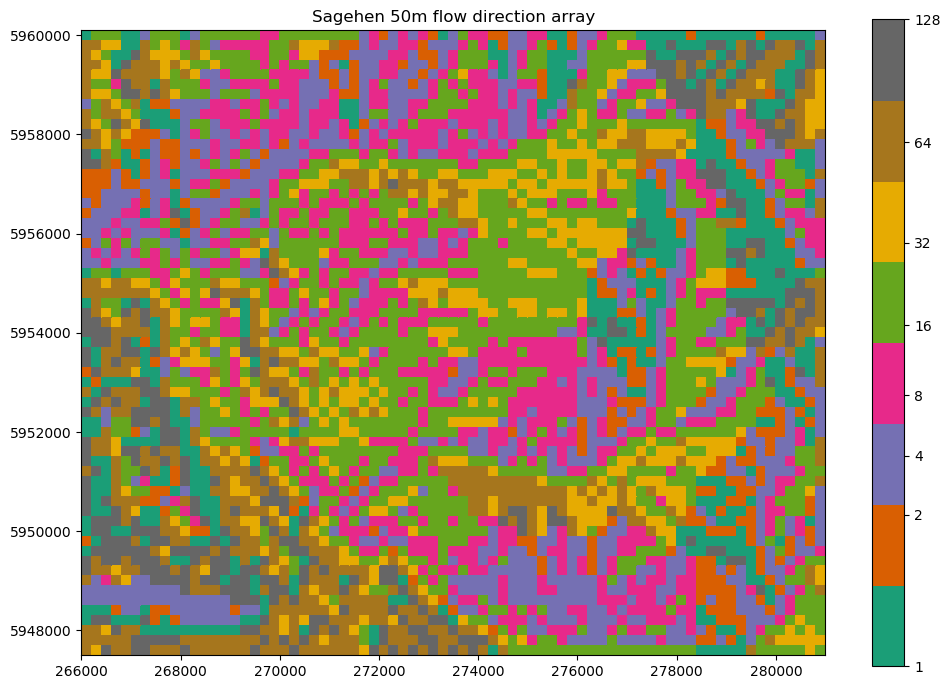

In [11]:
# plot the flow direction array
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pc = pmv.plot_array(
    flow_directions, vmin=1, vmax=128, cmap="Dark2", norm=mcolors.PowerNorm(0.3)
)
plt.title("Sagehen 50m flow direction array")
plt.colorbar(pc, shrink=0.7, ticks=[1, 2, 4, 8, 16, 32, 64, 128])
plt.show();

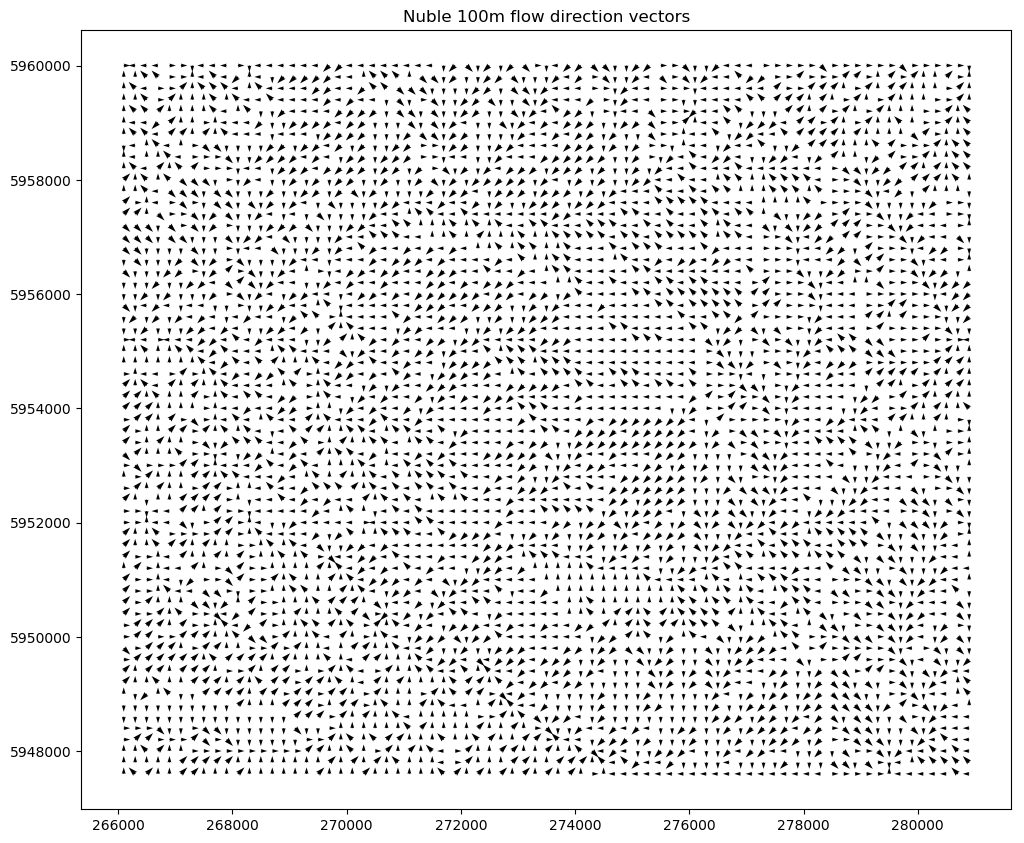

In [12]:
qx, qy = fa.get_vectors

# plot the flow directions as a quiver map
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
plt.quiver(modelgrid.xcellcenters, modelgrid.ycellcenters, qx, qy)
plt.title("Nuble 100m flow direction vectors")
plt.show();

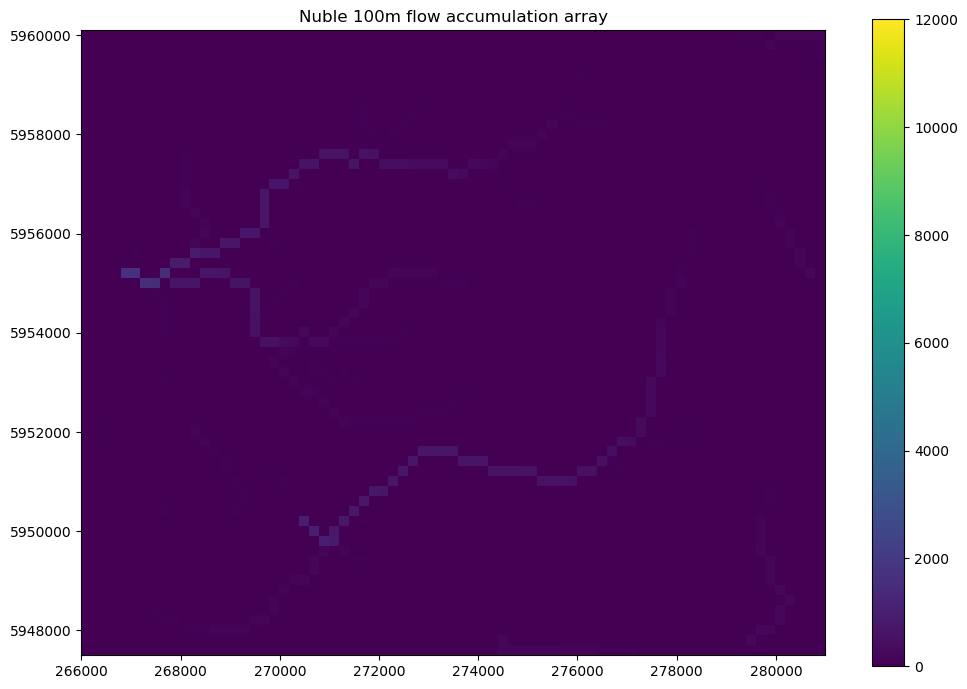

In [13]:
# run flow accumulation
flow_accumulation = fa.flow_accumulation()
# plot the flow accumulation array
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pc = pmv.plot_array(
    flow_accumulation, vmin=0, vmax=12000
)
plt.title("Nuble 100m flow accumulation array")
plt.colorbar(pc, shrink=0.7)
plt.show();

np.savetxt(
    os.path.join(output_ws, "esteros_100m_flowdir.txt"), 
    flow_directions.astype(int), 
    delimiter="  ", 
    fmt="%d")

np.savetxt(
    os.path.join(output_ws, "esteros_100m_flowacc.txt"),
    flow_accumulation,
    delimiter="  "
)

np.savetxt(
    os.path.join(output_ws, "esteros_100m_dem.txt"),
    fa.get_dem_data(),
    delimiter="  "
)

In [14]:
# define the input and output data paths
input_ws = os.path.join('..',"geodata")
shp_ws = os.path.join('..',"geodata")
output_ws = os.path.join('..', "temp")

# define the modelgrid and resampled DEM data paths
mg_file = os.path.join(input_ws, "esteros_100m_grid.bin")
dem_data = os.path.join(output_ws, "esteros_100m_dem.txt")

# define the flow direction and flow accumulation data paths
flowdir_file = os.path.join(output_ws, "esteros_100m_flowdir.txt")
flowacc_file = os.path.join(output_ws, "esteros_100m_flowacc.txt")

# shapefile pour point
shp_file = os.path.join(shp_ws, "model_points.shp")
modelgrid = GenerateFishnet.load_from_file(mg_file)
dem_data = np.genfromtxt(dem_data)
flow_directions = np.genfromtxt(flowdir_file)
flow_accumulation = np.genfromtxt(flowacc_file)
fa = FlowAccumulation(
    dem_data,
    modelgrid.xcellcenters,
    modelgrid.ycellcenters,
    flow_dir_array=flow_directions,
    verbose=True
)
# read in our pour point from a shapefile as an xy coordinate
with shapefile.Reader(shp_file) as r:
    shape = r.shape(0)
    pour_point = shape.points

print(pour_point)
watershed = fa.define_watershed(pour_point, modelgrid, fmt="xy")

[[272754.8047567228, 5951478.727719698]]


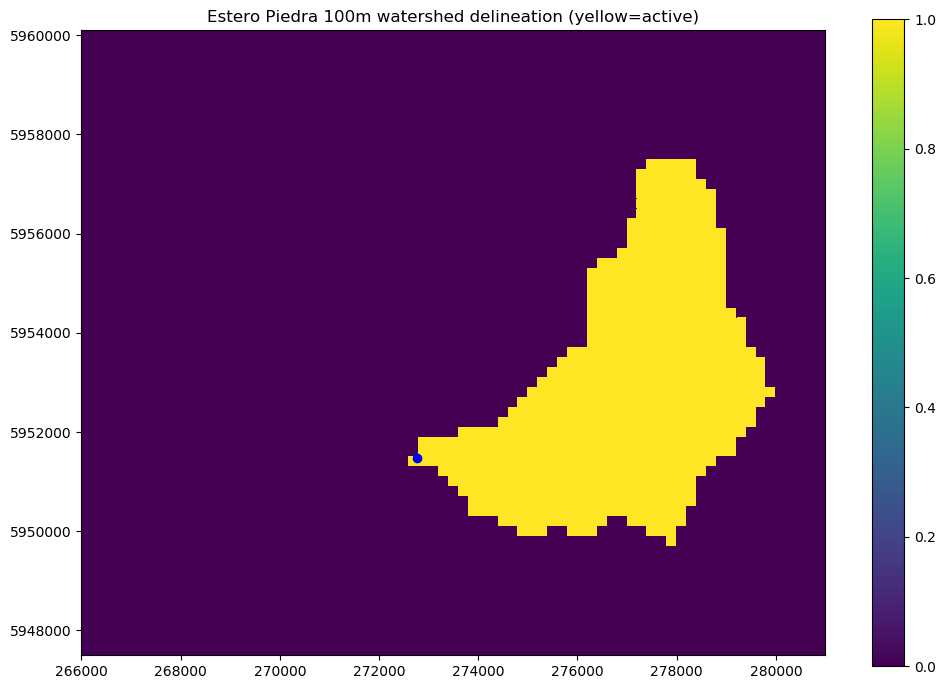

In [15]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pc = pmv.plot_array(
    watershed, vmin=0, vmax=1,
)
plt.plot(*pour_point[0], 'bo')
plt.colorbar(pc, shrink=0.7)
plt.title("Estero Piedra 100m watershed delineation (yellow=active)")
plt.show();

In [16]:
np.savetxt(
    os.path.join(output_ws, "esteros_100m_watershed.txt"),
    watershed.astype(int),
    delimiter="  ",
    fmt="%d"
)

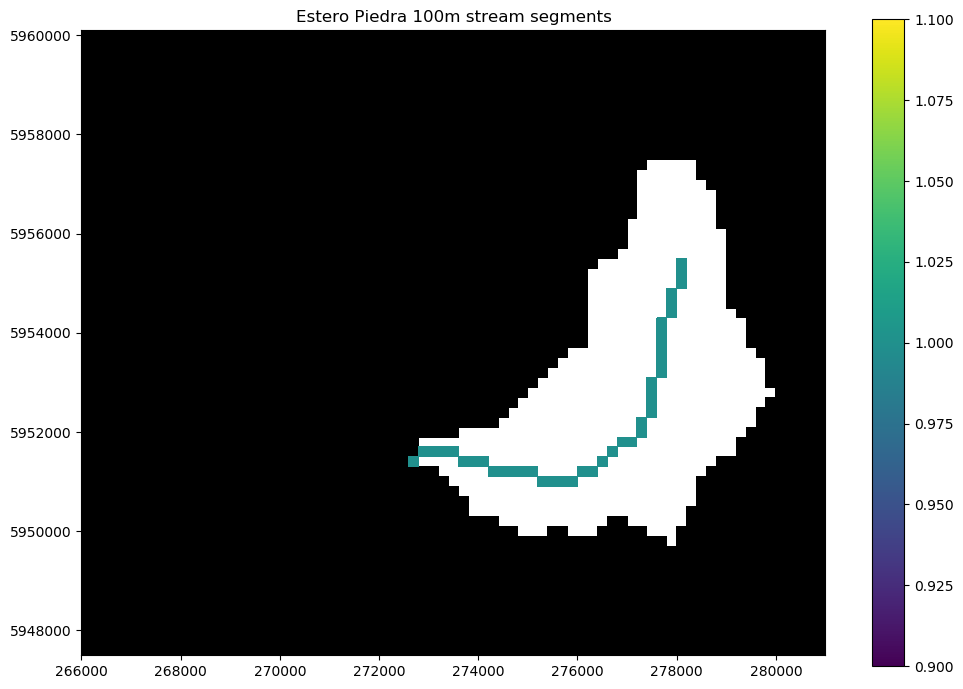

In [17]:
# create our threshold
threshold_m2 = 810000 
cellsize = 100
threshold = threshold_m2 / (cellsize ** 2)

# run make streams
strm_obj = fa.make_streams(
    flow_directions,
    flow_accumulation,
    threshold
)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
# plot the watershed boundary on top
ib = pmv.plot_ibound(ibound=watershed)
pc = pmv.plot_array(strm_obj.iseg, masked_values=[0,])

plt.colorbar(pc, shrink=0.7)
plt.title("Estero Piedra 100m stream segments")
plt.show();

In [18]:
cascades = fa.get_cascades(
    strm_obj,
    pour_point,
    modelgrid,
    fmt="xy"
)
strm_obj.write(os.path.join(output_ws, "esteros_100m_streams.bin"))
cascades.write(os.path.join(output_ws, "esteros_100m_cascades.bin"))
# get ncascades
print(cascades.ncascade)

672


In [19]:
# define the modelgrid and resampled DEM data paths
mg_file = os.path.join(input_ws, 'esteros_100m_grid.bin')
dem_data = os.path.join(output_ws, "esteros_100m_dem.txt")

# define the watershed data path
watershed_file = os.path.join(output_ws, "esteros_100m_watershed.txt")

# define the stream information binary data path
stream_file = os.path.join(output_ws, "esteros_100m_streams.bin")

# load modelgrid, dem, watershed, and stream information file
modelgrid = GenerateFishnet.load_from_file(mg_file)
dem_data = np.genfromtxt(dem_data)
watershed = np.genfromtxt(watershed_file, dtype=int)
strm_obj = FlowAccumulation.load_streams(stream_file)

In [20]:
mfbuild = ModflowBuilder(modelgrid, dem_data, "esteros_100m")
# set the botm elevation to be 100 m less than the top
botm = dem_data - 100
botm.shape = (1, modelgrid.nrow, modelgrid.ncol)

# build a DIS file
dis = mfbuild.build_dis(botm=botm)
bas6 = mfbuild.build_bas6(ibound=watershed)
upw = mfbuild.build_upw()
nwt = mfbuild.build_nwt()
oc = mfbuild.build_oc()
uzf = mfbuild.build_uzf(
    strm_obj.irunbnd,
    finf=np.ones(dem_data.shape),
    iuzfbnd=watershed
)
sfr = mfbuild.build_sfr(
    strm_obj.reach_data,
    strm_obj.segment_data
)
ml = mfbuild.model
# change the path of the model
ml.change_model_ws(output_ws)
ml.write_input()

# create a new modflow builder object
mfbuild = ModflowBuilder(modelgrid, dem_data, "esteros_100m")

# build the model
ml = mfbuild.build_all(
    strm_obj.reach_data,
    strm_obj.segment_data,
    strm_obj.irunbnd,
    finf=np.ones(dem_data.shape),
    botm=botm,
    ibound=watershed,
    iuzfbnd=watershed
)
# create data for perlen, nstp, tsmult, and the steady flag
perlen = [1, 5356]
nstp = [1, 5356]
tsmult = [1, 1]
steady = [True, False]

flopy.modflow.ModflowDis(
    ml,
    nlay=ml.dis.nlay,
    nrow=ml.dis.nrow,
    ncol=ml.dis.ncol,
    nper=2,
    delr=ml.dis.delr,
    delc=ml.dis.delc,
    laycbd=ml.dis.laycbd,
    top=ml.dis.top,
    botm=ml.dis.botm,
    perlen=perlen,
    nstp=nstp,
    tsmult=tsmult,
    steady=steady,
    itmuni=ml.dis.itmuni,
    lenuni=ml.dis.lenuni
)
# update hk using a multiplier, current value is 10
ml.upw.hk *= 1.75e-03

# show how to update the ss using a multiplier, current value is 1e-06 and appropriate for this model
ml.upw.ss *= 1.0
# update roughch in segment data
ml.sfr.segment_data[0]["roughch"] = 0.04

# update strhc1 in reach data
ml.sfr.reach_data["strhc1"] = 0.1

# copy the coordinate information from the modelgrid we built in Tutorial 1
ml.modelgrid.set_coord_info(
    xoff=modelgrid.xoffset, 
    yoff=modelgrid.yoffset
)
# change the path of the model and write to file
ml.change_model_ws(output_ws)
ml.write_input()
# set the path to the mfnwt executable
exe_name = os.path.join("..", "bin", "mfnwt")
exe_name += ".exe"

ml.exe_name = exe_name
success, buff = ml.run_model(silent=False)
print(success)

FloPy is using the following executable to run the model: ..\bin\mfnwt.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: esteros_100m.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/07/11 22:08:58

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Groundwater-Flow Eqn.
 Solving

 Solving:  Stress period:     2    Time step:   294    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   295    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   296    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   297    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   298    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   299    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   300    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   301    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   302    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   303    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   304    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   305    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   306    Groundwater-Flow Eqn.

 Solving:  Stress period:     2    Time step:   583    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   584    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   585    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   586    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   587    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   588    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   589    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   590    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   591    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   592    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   593    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   594    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   595    Groundwater-Flow Eqn.

 Solving:  Stress period:     2    Time step:   892    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   893    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   894    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   895    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   896    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   897    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   898    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   899    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   900    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   901    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   902    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   903    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   904    Groundwater-Flow Eqn.

 Solving:  Stress period:     2    Time step:  1189    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1190    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1191    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1192    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1193    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1194    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1195    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1196    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1197    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1198    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1199    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1200    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1201    Groundwater-Flow Eqn.

 Solving:  Stress period:     2    Time step:  1498    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1499    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1500    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1501    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1502    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1503    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1504    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1505    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1506    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1507    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1508    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1509    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1510    Groundwater-Flow Eqn.

 Solving:  Stress period:     2    Time step:  1827    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1828    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1829    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1830    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1831    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1832    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1833    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1834    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1835    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1836    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1837    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1838    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  1839    Groundwater-Flow Eqn.

 Solving:  Stress period:     2    Time step:  2142    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2143    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2144    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2145    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2146    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2147    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2148    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2149    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2150    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2151    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2152    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2153    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2154    Groundwater-Flow Eqn.

 Solving:  Stress period:     2    Time step:  2453    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2454    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2455    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2456    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2457    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2458    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2459    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2460    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2461    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2462    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2463    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2464    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2465    Groundwater-Flow Eqn.

 Solving:  Stress period:     2    Time step:  2706    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2707    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2708    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2709    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2710    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2711    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2712    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2713    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2714    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2715    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2716    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2717    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  2718    Groundwater-Flow Eqn.

 Solving:  Stress period:     2    Time step:  3010    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3011    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3012    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3013    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3014    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3015    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3016    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3017    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3018    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3019    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3020    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3021    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3022    Groundwater-Flow Eqn.

 Solving:  Stress period:     2    Time step:  3323    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3324    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3325    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3326    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3327    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3328    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3329    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3330    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3331    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3332    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3333    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3334    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3335    Groundwater-Flow Eqn.

 Solving:  Stress period:     2    Time step:  3636    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3637    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3638    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3639    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3640    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3641    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3642    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3643    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3644    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3645    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3646    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3647    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3648    Groundwater-Flow Eqn.

 Solving:  Stress period:     2    Time step:  3953    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3954    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3955    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3956    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3957    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3958    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3959    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3960    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3961    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3962    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3963    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3964    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  3965    Groundwater-Flow Eqn.

 Solving:  Stress period:     2    Time step:  4264    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4265    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4266    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4267    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4268    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4269    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4270    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4271    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4272    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4273    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4274    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4275    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4276    Groundwater-Flow Eqn.

 Solving:  Stress period:     2    Time step:  4577    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4578    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4579    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4580    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4581    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4582    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4583    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4584    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4585    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4586    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4587    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4588    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4589    Groundwater-Flow Eqn.

 Solving:  Stress period:     2    Time step:  4896    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4897    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4898    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4899    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4900    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4901    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4902    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4903    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4904    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4905    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4906    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4907    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  4908    Groundwater-Flow Eqn.

 Solving:  Stress period:     2    Time step:  5214    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  5215    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  5216    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  5217    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  5218    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  5219    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  5220    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  5221    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  5222    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  5223    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  5224    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  5225    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  5226    Groundwater-Flow Eqn.

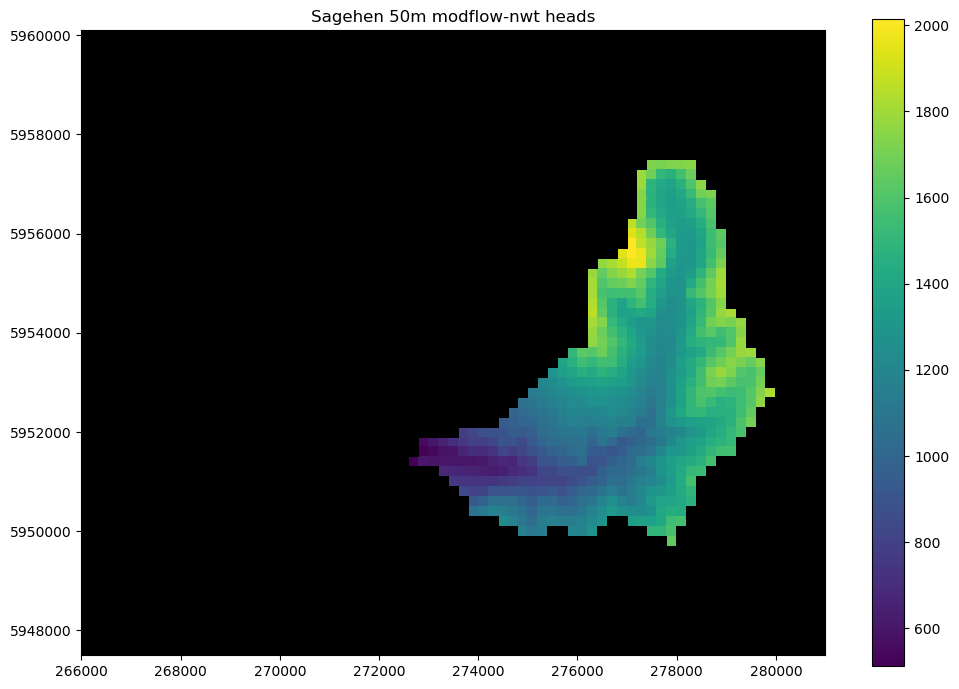

In [21]:
# define the headfile path
head_file = os.path.join(output_ws, "esteros_100m.hds")

# load the headfile
hds = flopy.utils.HeadFile(head_file)

# get data
heads = hds.get_alldata()[-1]
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(model=ml, ax=ax)
pc = pmv.plot_array(heads)
ib = pmv.plot_inactive()
plt.colorbar(pc, shrink=0.7)
plt.title("Sagehen 50m modflow-nwt heads")
plt.show();
# adjust SFR flow parameter to zero
ml.sfr.segment_data[0]["flow"] *= 0 

# write the model to file
ml.write_input()

In [22]:
cascade_file = os.path.join(output_ws, "esteros_100m_cascades.bin")
# load modelgrid, dem, watershed, stream information, and cascade routing file
modelgrid = GenerateFishnet.load_from_file(mg_file)
watershed = np.genfromtxt(watershed_file, dtype=int)
strm_obj = FlowAccumulation.load_streams(stream_file)
cascades = FlowAccumulation.load_cascades(cascade_file)

prmsbuild = PrmsBuilder(
    strm_obj,
    cascades,
    modelgrid,
    dem_data.ravel(),
    hru_type=watershed.ravel(),
    hru_subbasin=watershed.ravel()
)
parameters = prmsbuild.build()


ssr2gw_rate = parameters.get_record("ssr2gw_rate")

lat, lon = utm.to_latlon(
    modelgrid.xcellcenters.ravel(),
    modelgrid.ycellcenters.ravel(),
    10,
    "N"
)

# set hru_lat and hru_lon values, using dynamic methods
parameters.hru_lat = lat
parameters.hru_lon = lon
if not np.allclose(parameters.hru_lat.values, lat):
    raise Exception()

if not np.allclose(parameters.hru_lon.values, lon):
    raise Exception()

param_file = os.path.join(output_ws, "esteros_100m_initial.param")
parameters.write(param_file)
# define the input and output data paths
modflow_nam = "esteros_100m.nam"
parameter_file = os.path.join(output_ws, "esteros_100m_initial.param")
ml = gsflow.modflow.Modflow.load(modflow_nam, model_ws=output_ws)
parameters = gsflow.prms.PrmsParameters.load_from_file(parameter_file)
controlbuild = ControlFileBuilder()
control = controlbuild.build("esteros_100m", parameters, ml)

mf_name = control.get_record("modflow_name")

control.model_mode = ["GSFLOW5",]

control.srunoff_module = ["srunoff_smidx",]

control_file = os.path.join(output_ws, "esteros_100m_initial.control")
control.write(control_file)


   loading iuzfbnd array...
   loading irunbnd array...
   loading vks array...
   loading eps array...
   loading thts array...
stress period 1:
   loading finf array...
stress period 2:
------------------------------------
Reading parameter file : esteros_100m_initial.param
------------------------------------


In [27]:
# define the input and output data paths
geospatial_ws = input_ws

# Set modflow model and the prms parameter file paths
modflow_nam = "esteros_100m.nam"
parameter_file = os.path.join(output_ws, "esteros_100m_initial.param")

# set the flow direction array path
fdir_file = os.path.join(output_ws, "esteros_100m_flowdir.txt")

ml = gsflow.modflow.Modflow.load(modflow_nam, model_ws=output_ws)
parameters = gsflow.prms.PrmsParameters.load_from_file(parameter_file)

# check the modelgrid coordinate information to make sure it loaded properly
print(ml.modelgrid.xoffset, ml.modelgrid.yoffset)

# load the flow direction array
flow_directions = np.genfromtxt(fdir_file)

resample_rasters = True

   loading iuzfbnd array...
   loading irunbnd array...
   loading vks array...
   loading eps array...
   loading thts array...
stress period 1:
   loading finf array...
stress period 2:
------------------------------------
Reading parameter file : esteros_100m_initial.param
------------------------------------
266000.0 5947500.0


In [30]:
# NLCD impervious land cover
impervious_raster = os.path.join(geospatial_ws, "nlcd2011_imp_utm.tif")

# ssurgo soil raster data
awc_raster = os.path.join(geospatial_ws, "awc.tif")
clay_raster = os.path.join(geospatial_ws, "clay.tif")
sand_raster = os.path.join(geospatial_ws, "sand.tif")
ksat_raster = os.path.join(geospatial_ws, "ksat.tif")

# Landfile vegetation type and cover raster data
veg_type_raster = os.path.join(geospatial_ws, "tipoRaster.tif")
veg_cov_raster = os.path.join(geospatial_ws, "usoRaster.tif")

In [28]:
# resample impervious land cover raster
if resample_rasters:
    rs_file = os.path.join(output_ws, "impervious_50m.txt")
    raster = flopy.utils.Raster.load(impervious_raster)
    impervious = raster.resample_to_grid(
            ml.modelgrid,
            band=raster.bands[0],
            method="median",
            multithread=True,
            thread_pool=12
        )
    impervious[ml.modelgrid.idomain[0] == 0] = 0
    impervious /= 100
    np.savetxt(rs_file, impervious)

c:\Users\Carlos\Anaconda3\envs\simcopiapo\lib\site-packages\flopy\utils\rasters.py:380: UserWarning: multithread option has been deprecated and will be removed in flopy version 3.3.8
  "multithread option has been deprecated and will be removed "
c:\Users\Carlos\Anaconda3\envs\simcopiapo\lib\site-packages\rasterstats\io.py:329: NodataWarning: Setting nodata to -999; specify nodata explicitly
  "Setting nodata to -999; specify nodata explicitly", NodataWarning


In [32]:
# resample SSURGO soil raster data
if resample_rasters:
    # create a loop to reduce code and clutter
    rs_files = [
        os.path.join(output_ws, "awc_50m.txt"), 
        os.path.join(output_ws, "clay_50m.txt"),
        os.path.join(output_ws, "sand_50m.txt"),
        os.path.join(output_ws, "ksat_50m.txt")
    ]
    
    ssurgo_rasters = [
        awc_raster,
        clay_raster,
        sand_raster,
        ksat_raster
    ]
    
    for ix, raster_file in enumerate(ssurgo_rasters):
        print("Resampling: {}".format(os.path.split(raster_file)[-1]))
        rs_file = rs_files[ix]
        raster = flopy.utils.Raster.load(raster_file)
        array = raster.resample_to_grid(
            ml.modelgrid,
            band=raster.bands[0],
            method="median",
            multithread=True,
            thread_pool=12
        )
        array[ml.modelgrid.idomain[0] == 0] = 0
        array[array == raster.nodatavals[0]] = np.nanmedian(array)
        array /= 10000
        
        np.savetxt(rs_file, array)

Resampling: awc.tif


c:\Users\Carlos\Anaconda3\envs\simcopiapo\lib\site-packages\flopy\utils\rasters.py:380: UserWarning: multithread option has been deprecated and will be removed in flopy version 3.3.8
  "multithread option has been deprecated and will be removed "


Resampling: clay.tif


c:\Users\Carlos\Anaconda3\envs\simcopiapo\lib\site-packages\flopy\utils\rasters.py:380: UserWarning: multithread option has been deprecated and will be removed in flopy version 3.3.8
  "multithread option has been deprecated and will be removed "


Resampling: sand.tif


c:\Users\Carlos\Anaconda3\envs\simcopiapo\lib\site-packages\flopy\utils\rasters.py:380: UserWarning: multithread option has been deprecated and will be removed in flopy version 3.3.8
  "multithread option has been deprecated and will be removed "


Resampling: ksat.tif


c:\Users\Carlos\Anaconda3\envs\simcopiapo\lib\site-packages\flopy\utils\rasters.py:380: UserWarning: multithread option has been deprecated and will be removed in flopy version 3.3.8
  "multithread option has been deprecated and will be removed "


In [33]:
# resample Landfire vegetative type and cover
if resample_rasters:
    # create a loop to reduce code and clutter
    rs_files = [
        os.path.join(output_ws, "veg_type_50m.txt"), 
        os.path.join(output_ws, "veg_cov_50m.txt"),
    ]
    
    landfire_rasters = [
        veg_type_raster,
        veg_cov_raster,
    ]
    
    for ix, raster_file in enumerate(landfire_rasters):
        print("Resampling: {}".format(os.path.split(raster_file)[-1]))
        rs_file = rs_files[ix]
        raster = flopy.utils.Raster.load(raster_file)
        array = raster.resample_to_grid(
            ml.modelgrid,
            band=raster.bands[0],
            method="nearest",
            multithread=True,
            thread_pool=12
        )
        array[ml.modelgrid.idomain[0] == 0] = 0
        array = array.astype(int)
        np.savetxt(rs_file, array, fmt="%d")

Resampling: tipoRaster.tif
Resampling: usoRaster.tif


c:\Users\Carlos\Anaconda3\envs\simcopiapo\lib\site-packages\flopy\utils\rasters.py:380: UserWarning: multithread option has been deprecated and will be removed in flopy version 3.3.8
  "multithread option has been deprecated and will be removed "
c:\Users\Carlos\Anaconda3\envs\simcopiapo\lib\site-packages\flopy\utils\rasters.py:380: UserWarning: multithread option has been deprecated and will be removed in flopy version 3.3.8
  "multithread option has been deprecated and will be removed "


In [57]:
# impervious coverage
impervious_file = os.path.join(output_ws, "impervious_50m.txt")

# ssurgo soil coverages
awc_file = os.path.join(output_ws, "awc_50m.txt")
clay_file = os.path.join(output_ws, "clay_50m.txt")
sand_file = os.path.join(output_ws, "sand_50m.txt")
ksat_file = os.path.join(output_ws, "ksat_50m.txt")

# vegetative coverages
veg_type_file = os.path.join(output_ws, "veg_type_50m.txt")
veg_cov_file = os.path.join(output_ws, "veg_cov_50m.txt")

In [58]:
# impervious coverage
impervious = np.genfromtxt(impervious_file)

# ssurgo soil coverages
awc = np.genfromtxt(awc_file)
clay = np.genfromtxt(clay_file)
sand = np.genfromtxt(sand_file)
ksat = np.genfromtxt(ksat_file)

# vegetative coverages
veg_type = np.genfromtxt(veg_type_file, dtype=int)
veg_cov = np.genfromtxt(veg_cov_file, dtype=int)

In [68]:
remap_ws = os.path.join('..',"data", "remap")

# cover type remap file
covtype_remap = os.path.join(remap_ws, "covtype.rmp")

# cover density remap files
covden_sum_remap = os.path.join(remap_ws, "covdensum.rmp")
covden_win_remap = os.path.join(remap_ws, "covdenwin.rmp")

# snow interception remap file
snow_intcp_remap = os.path.join(remap_ws, "snow_intcp.rmp")

# rain interception remap file
srain_intcp_remap = os.path.join(remap_ws, "srain_intcp.rmp")

# rooting depth remap file
root_depth_remap = os.path.join(remap_ws, "rtdepth.rmp")

In [69]:
from gsflow.builder import builder_utils as bu
covtype_lut = bu.build_lut(covtype_remap)
covden_sum_lut = bu.build_lut(covden_sum_remap)
covden_win_lut = bu.build_lut(covden_win_remap)
snow_intcp_lut = bu.build_lut(snow_intcp_remap)
srain_intcp_lut = bu.build_lut(srain_intcp_remap)
root_depth_lut = bu.build_lut(root_depth_remap)
type(covtype_lut)

dict

In [70]:
# prms covtype
covtype = bu.covtype(veg_type, covtype_lut)

# covden_sum (summer cover density)
covden_sum = bu.covden_sum(veg_cov, covden_sum_lut)

# covden_win (winter cover density)
covden_win = bu.covden_win(covtype.values, covden_win_lut)

# rad_trncf (short-wave winter radiation coefficient through canopy)
rad_trncf = bu.rad_trncf(covden_win.values)

# snow_intcp (canopy interception coefficient for snow)
snow_intcp = bu.snow_intcp(veg_type, snow_intcp_lut)

# srain_intcp (canopy interception coefficient for summer rain)
srain_intcp = bu.srain_intcp(veg_type, srain_intcp_lut)

# wrain_intcp (canopy interception coefficient for winter rain)
wrain_intcp = bu.wrain_intcp(veg_type, snow_intcp_lut)

print(covtype)
print(type(covtype))


####
cov_type 10
1
nhru
4725
1
0
0
0
0.
.
.
####
<class 'gsflow.prms.prms_parameter.ParameterRecord'>


In [71]:
parameters.add_record_object(covtype)
parameters.add_record_object(covden_sum)
parameters.add_record_object(covden_win)
parameters.add_record_object(rad_trncf)
parameters.add_record_object(snow_intcp)
parameters.add_record_object(srain_intcp)
parameters.add_record_object(wrain_intcp)

In [72]:
# calculate the root depth from veg_type for use in soil parameters
root_depth = bu.root_depth(veg_type, root_depth_lut)

hru_aspect = bu.d8_to_hru_aspect(flow_directions)
hru_slope = bu.d8_to_hru_slope(
    flow_directions,
    ml.modelgrid.top,
    ml.modelgrid.xcellcenters,
    ml.modelgrid.ycellcenters
)

In [74]:
cellsize = 200
soil_type = bu.soil_type(clay, sand)

# soil moisture params
soil_moist_max = bu.soil_moist_max(awc, root_depth)
soil_moist_init = bu.soil_moist_init(soil_moist_max.values)

# soil recharge params
soil_rech_max = bu.soil_rech_max(awc, root_depth)
soil_rech_init = bu.soil_rech_init(soil_rech_max.values)

# gravity reservoir routing coefficients
ssr2gw_rate = bu.ssr2gw_rate(ksat, sand, soil_moist_max.values)
ssr2gw_sq = bu.ssr2gw_exp(ml.modelgrid.nnodes)

# slow flow gravity reservoir routing coefficients
slowcoef_lin = bu.slowcoef_lin(ksat, hru_aspect.values, cellsize, cellsize)
slowcoef_sq = bu.slowcoef_sq(
    ksat, hru_aspect.values, sand, soil_moist_max.values, cellsize, cellsize
)

In [75]:
parameters.add_record_object(hru_slope)
parameters.add_record_object(hru_aspect)
parameters.add_record_object(soil_type)
parameters.add_record_object(soil_moist_max)
parameters.add_record_object(soil_moist_init)
parameters.add_record_object(soil_rech_max)
parameters.add_record_object(soil_rech_init)
parameters.add_record_object(ssr2gw_rate)
parameters.add_record_object(ssr2gw_sq)
parameters.add_record_object(slowcoef_lin)
parameters.add_record_object(slowcoef_sq)

In [76]:
# build the percent impervious parameter
hru_percent_imperv = bu.hru_percent_imperv(impervious)

# build the maximum contributing area parameter
carea_max = bu.carea_max(impervious)

In [77]:
parameters.add_record_object(hru_percent_imperv)
parameters.add_record_object(carea_max)

In [78]:
parameters.write(os.path.join(output_ws, "piedra_100m_lu_soil.params"))

In [91]:
# define the input and output data paths

# Set modflow model and the prms parameter file paths
parameter_file = os.path.join(output_ws, "piedra_100m_lu_soil.params")

# set the pour point shapefile path
shp_file = os.path.join(geospatial_ws, "model_points.shp")

ml = gsflow.modflow.Modflow.load(modflow_nam, model_ws=output_ws)
parameters = gsflow.prms.PrmsParameters.load_from_file(parameter_file)

# check the modelgrid coordinate information to make sure it loaded properly
print(ml.modelgrid.xoffset, ml.modelgrid.yoffset)

   loading iuzfbnd array...
   loading irunbnd array...
   loading vks array...
   loading eps array...
   loading thts array...
stress period 1:
   loading finf array...
stress period 2:
------------------------------------
Reading parameter file : piedra_100m_lu_soil.params
------------------------------------
266000.0 5947500.0


In [94]:
climate_ws=os.path.join('..','geodata','clima')

In [99]:
prism = {"pp": [], "tmax": [], "tmin": []}
for folder in prism.keys():
    for f in os.listdir(climate_ws):
        if folder in f and f.endswith(".tif"):
            prism[folder].append(os.path.join(climate_ws,f))

# inspect ppt to make sure we've collected all of the precip filenames
for f in prism["pp"]:
    print(os.path.split(f)[-1])

pp0.tif
pp1.tif
pp10.tif
pp11.tif
pp2.tif
pp3.tif
pp4.tif
pp5.tif
pp6.tif
pp7.tif
pp8.tif
pp9.tif


In [104]:
# loop over all the datatypes and rasters to create a single yearly resampled file with monthly values entries
if resample_rasters:
    rs_files = {
        "pp": os.path.join(output_ws, "ppt_50m.txt"),
        "tmax": os.path.join(output_ws, "tmax_50m.txt"),
        "tmin": os.path.join(output_ws, "tmin_50m.txt")
    }
    
    # create a loop to reduce code clutter
    for ctype, raster_list in prism.items():
        output = []
        rs_file = rs_files[ctype]
        for raster_file in raster_list:
            raster = flopy.utils.Raster.load(raster_file)
            array = raster.resample_to_grid(
                ml.modelgrid,
                band=raster.bands[0],
                method="linear",
            )
            output.append(array.ravel())
        output = np.array(output)
        print(os.path.split(rs_file)[-1])
        np.savetxt(rs_file, output)

ppt_file = os.path.join(output_ws, "ppt_50m.txt")
tmax_file = os.path.join(output_ws, "tmax_50m.txt")
tmin_file = os.path.join(output_ws, "tmin_50m.txt")

nhru = ml.modelgrid.nnodes
print(nhru)
ppt = np.genfromtxt(ppt_file).reshape(12, nhru)
tmax = np.genfromtxt(tmax_file).reshape(12, nhru)
tmin = np.genfromtxt(tmin_file).reshape(12, nhru)

ppt_50m.txt
tmax_50m.txt
tmin_50m.txt
4725


In [107]:
with shapefile.Reader(shp_file) as r:
    pour_point = r.shape(0).points

# get the zero based node number of the outlet station
outlet_sta = ml.modelgrid.intersect(*pour_point[0])
outlet_sta = ml.modelgrid.get_node([(0,) + outlet_sta])

parameters.add_record(name="nobs", values=[1,])

parameters.add_record(
    "outlet_sta",
    values=[outlet_sta[0] + 1,],
    dimensions=[["one", 1]],
    datatype=1
)

parameters.add_record(
    "id_obsrunoff",
    values=[outlet_sta[0] + 1, ],
    dimensions=[["one", 1]],
    datatype=1
)

In [110]:
parameters.write(os.path.join(output_ws, "sagehen_50m_ncal.param"))
# change the model workspace for this control file
control.model_dir = output_ws

# write
control.write("sagehen_cbh_ex.control")